In [1]:
pip install segmentation-models-pytorch torch albumentations pytorch_lightning pandas numpy matplotlib opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 931.7 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5cb0cda86bf9c375caee7c867ab24c62bf67cb1fa2f5ba5118d869b5a565f234
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6a179b4cb07c7cc253cc7cf0433365dba70c210567cd986bbb2698d7391f4484
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

import albumentations as aug

import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch.encoders import get_encoder
import segmentation_models_pytorch as smp


In [3]:
IMAGE_SIZE = 320
BATCH_SIZE = 16
EPOCHS = 5

color_dict = pd.read_csv('/kaggle/input/processed/PROCESSED/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

          name    r    g    b
0        Urban    0  255  255
1  Agriculture  255  255    0
2         Road  255    0  255
3       Forest    0  255    0
4        Water    0    0  255
5       Barren  255  255  255
6      unknown    0    0    0


In [4]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("/kaggle/input/processed/PROCESSED/SATELLITE/*.jpg")),
    'MASKS': sorted(glob("/kaggle/input/processed/PROCESSED/MASK/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,/kaggle/input/processed/PROCESSED/SATELLITE/50...,/kaggle/input/processed/PROCESSED/MASK/504704_...
1,/kaggle/input/processed/PROCESSED/SATELLITE/51...,/kaggle/input/processed/PROCESSED/MASK/511850_...
2,/kaggle/input/processed/PROCESSED/SATELLITE/15...,/kaggle/input/processed/PROCESSED/MASK/154626_...
3,/kaggle/input/processed/PROCESSED/SATELLITE/43...,/kaggle/input/processed/PROCESSED/MASK/439854_...
4,/kaggle/input/processed/PROCESSED/SATELLITE/PH...,/kaggle/input/processed/PROCESSED/MASK/PHOTO-2...


In [5]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.25, random_state=0)
pd_train, pd_val = train_test_split(pd_train, test_size=0.2, random_state=0)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 525
Validation set size: 132
Testing set size: 220


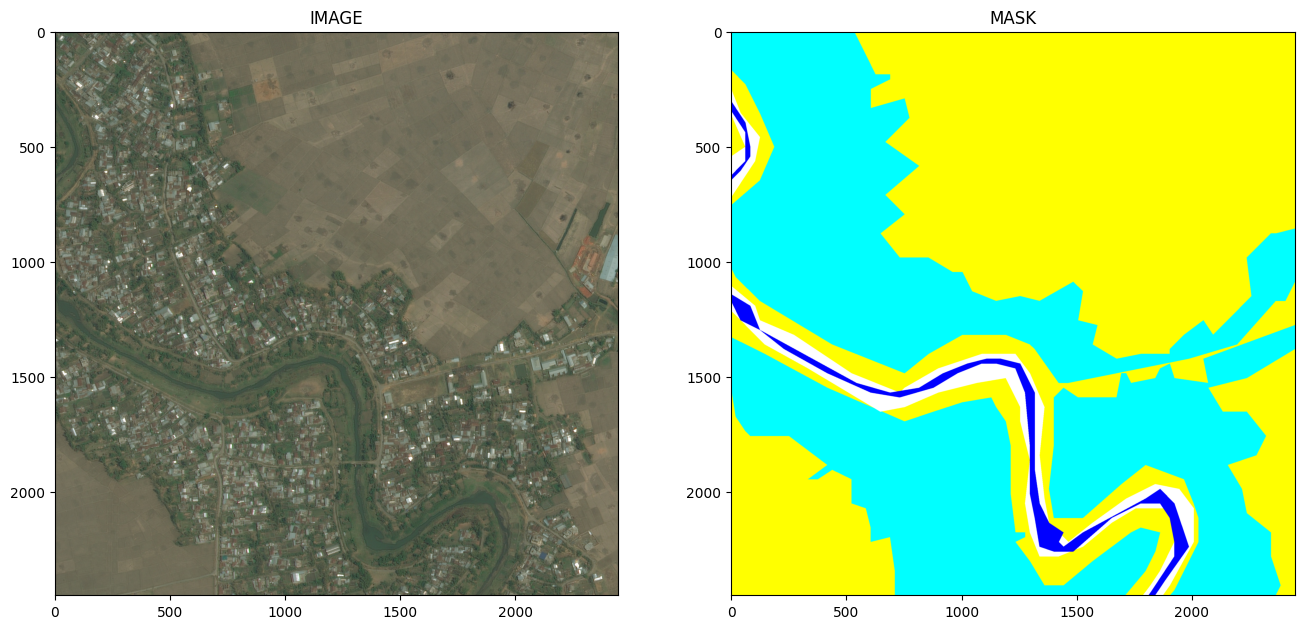

In [6]:
index = 200

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [7]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [8]:
import albumentations as aug

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

In [9]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [10]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment)
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment)
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [11]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [12]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([16, 3, 320, 320]), torch.Size([16, 1, 320, 320]))

In [13]:
import ssl
import torch

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModelHRNet(pl.LightningModule):
    def __init__(self, encoder_name='inceptionv4', encoder_weights='imagenet', num_classes=7, lr=1e-3):
        super().__init__()
        self.model = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, classes=num_classes, activation='softmax')
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [15]:
from torchinfo import summary

model = SegmentationModelHRNet()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth
100%|██████████| 163M/163M [08:00<00:00, 356kB/s] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModelHRNet                                  [16, 7, 320, 320]         --
├─Unet: 1-1                                             [16, 7, 320, 320]         --
│    └─InceptionV4Encoder: 2-1                          [16, 3, 320, 320]         --
│    │    └─Sequential: 3-1                             --                        41,142,816
│    └─UnetDecoder: 2-2                                 [16, 16, 320, 320]        --
│    │    └─Identity: 3-2                               [16, 1536, 10, 10]        --
│    │    └─ModuleList: 3-3                             --                        7,648,960
│    └─SegmentationHead: 2-3                            [16, 7, 320, 320]         --
│    │    └─Conv2d: 3-4                                 [16, 7, 320, 320]         1,015
│    │    └─Identity: 3-5                               [16, 7, 320, 320]         --
│    │    └─Activation: 3-6               

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [17]:
trainer.fit(model, data_module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [18]:
trainer.test(model, data_module)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9758280515670776     │
│       test/F1score        │    0.9153981804847717     │
│         test/IoU          │    0.8442411422729492     │
│         test/Loss         │    0.1907842457294464     │
│      test/Precision       │    0.9153981804847717     │
│        test/Recall        │    0.9153981804847717     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.1907842457294464,
  'test/IoU': 0.8442411422729492,
  'test/Accuracy': 0.9758280515670776,
  'test/Precision': 0.9153981804847717,
  'test/Recall': 0.9153981804847717,
  'test/F1score': 0.9153981804847717}]

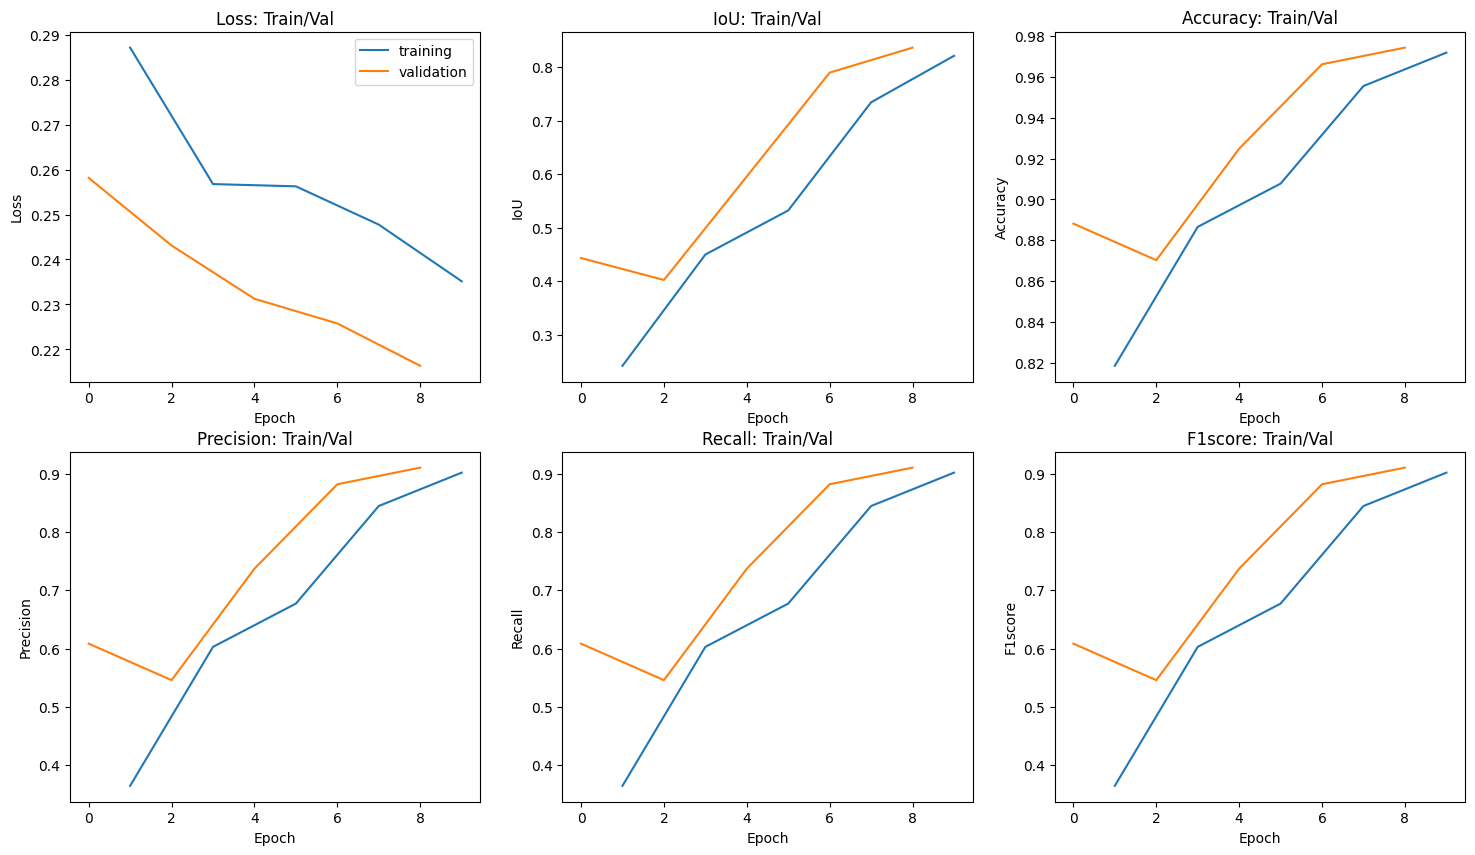

In [19]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")